# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Identifying the Problem


We want to assess the current purchasing behavior of Starbucks mobile App costumers. We need to understand the response of the costumers as a result of various offer types, build ML model to predict whether or not the customer will respond to the offers, and finally, what are the type of offers the customers will respond to.

My strategy for solving this problem will include assesing the offers' attributes and the demographic data.

## Exploring the data

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns

% matplotlib inline
import matplotlib.pyplot as plt

import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# for modeling
portfolio_2 = portfolio.copy()
profile_2 = profile.copy()
transcript_2 = transcript.copy()

In [3]:
"""
**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)
"""


portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
"""
**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income
"""


profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [5]:
"""
**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record
"""

transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


#### Visualizing the data

In [6]:
profile.became_member_on = pd.to_datetime(profile.became_member_on.astype(int), format='%Y%m%d')

profile_by_date = profile.set_index(['became_member_on'])
profile_by_date = profile_by_date.sort_index()
profile_by_gender = profile[['id', 'gender']].groupby(by='gender').agg({'id': lambda x: len(x) / len(profile) * 100}).reset_index()

profile_by_date.head()

,age,gender,id,income
became_member_on,,,,
2013-07-29,64,M,77388a70eaf14433b4efc5d01fa947bf,69000.0
2013-07-30,58,F,d25f38519a89455499c9e49e67ae1511,55000.0
2013-07-30,52,M,5ffdab087e674149a89324a732b4f993,65000.0
2013-07-30,36,M,dbb4766b7dd94ca2b83a855312a3ebe9,74000.0
2013-07-31,67,F,7b42b5bbe237406aaf2748a09050f745,58000.0


In [7]:
profile_by_gender

,gender,id
0,F,36.052941
1,M,49.905882
2,O,1.247059


In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


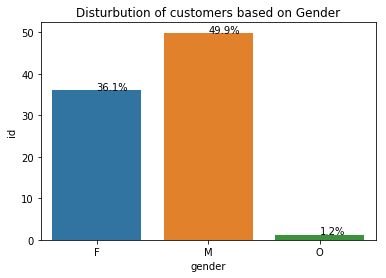

In [9]:

ax = sns.barplot(x="gender", y="id", data=profile_by_gender)
# id in the above dataframe is the count of ids

for i in range(0, len(profile_by_gender)):
    ax.text(i, profile_by_gender['id'].iloc[i],  '{:.1%}'.format(profile_by_gender['id'].iloc[i]/100))


plt.title('Disturbution of customers based on Gender');


In [10]:
# it looks like male represent a little less than 60% of our dataset while females represent around 40%.

In [11]:
profile_by_date.head()

,age,gender,id,income
became_member_on,,,,
2013-07-29,64,M,77388a70eaf14433b4efc5d01fa947bf,69000.0
2013-07-30,58,F,d25f38519a89455499c9e49e67ae1511,55000.0
2013-07-30,52,M,5ffdab087e674149a89324a732b4f993,65000.0
2013-07-30,36,M,dbb4766b7dd94ca2b83a855312a3ebe9,74000.0
2013-07-31,67,F,7b42b5bbe237406aaf2748a09050f745,58000.0


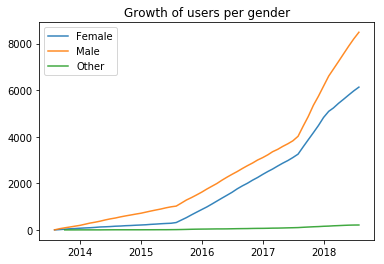

In [12]:

figure = plt.subplots()


plt.plot(profile_by_date[profile_by_date.gender=='F']['id'].resample('M').count().cumsum(), alpha=0.9, label='Female')

plt.plot(profile_by_date[profile_by_date.gender=='M']['id'].resample('M').count().cumsum(), alpha=0.9, label='Male')
plt.plot(profile_by_date[profile_by_date.gender=='O']['id'].resample('M').count().cumsum(), alpha=0.9, label='Other')


plt.title("Growth of users per gender")


plt.legend();


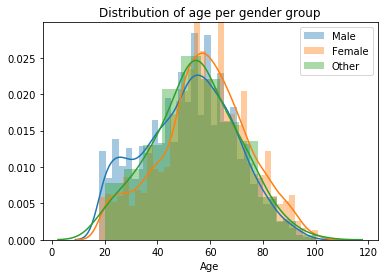

In [13]:

sns.distplot(profile[profile['gender']=='M']['age'],  label="Male");
sns.distplot(profile[profile['gender']=='F']['age'],  label="Female");
sns.distplot(profile[profile['gender']=='O']['age'],  label="Other");

plt.title('Distribution of age per gender group')
plt.xlabel("Age")

plt.legend();


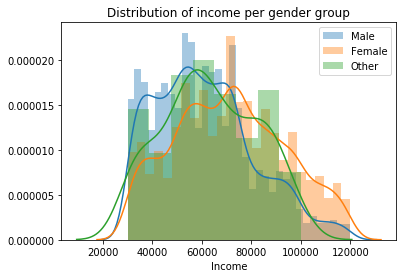

In [14]:
sns.distplot(profile[(profile['gender']=='M')]['income'],label="Male");
sns.distplot(profile[(profile['gender']=='F')]['income'],label="Female");
sns.distplot(profile[(profile['gender']=='O')]['income'],label="Other");

plt.title('Distribution of income per gender group')
plt.xlabel("Income")

plt.legend();


### Transcript


In [15]:
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) 
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) 

transcript.head()


,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


In [16]:
transcript.head(-1)


,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,offer id
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,offer id
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,offer id
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id


In [17]:
transcript.value_type.unique()

array(['offer id', 'amount', 'offer_id'], dtype=object)

In [18]:
#now we know what does the value represent in the value column!

In [19]:
transcript.event.unique()


array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [20]:
transcript[['event', 'person']].groupby(by=["event"]).agg({'person':'count'}).sort_values(by='person', ascending=False).reset_index()


,event,person
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


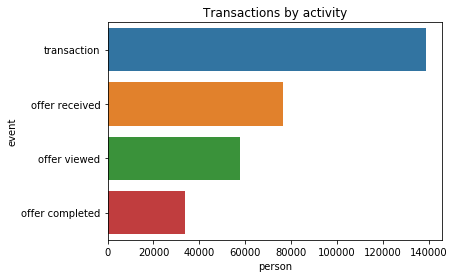

In [21]:
transcript_by_type = transcript[['event', 'person']].groupby(by=["event"]).agg({'person':'count'}).sort_values(by='person', ascending=False).reset_index()
axis = sns.barplot(x="person", y="event", data=transcript_by_type)




plt.title('Transactions by activity');


In [22]:
transcript_by_type

,event,person
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [23]:
transcript_by_type['person'].iloc[3]/transcript_by_type['person'].iloc[1]


0.4402244451145168

It looks like only 44% of the offers are completed.

In [24]:
offers=transcript.groupby('event')

transaction=offers.get_group('transaction')

completed=offers.get_group('offer completed')
received=offers.get_group('offer received')
viewed=offers.get_group('offer viewed')
viewed

,event,person,time,value,value_type
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,offer id
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837,offer id
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd,offer id
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837,offer id
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer id
12660,offer viewed,8c7df0c393db488aac3e58b06a7ea5f9,0,2298d6c36e964ae4a3e7e9706d1fb8c2,offer id
12661,offer viewed,e528ceb341964128aaf58a59733ec2af,0,2298d6c36e964ae4a3e7e9706d1fb8c2,offer id
12662,offer viewed,262ad0fb526a4d53b572007da60cce24,0,f19421c1d4aa40978ebb69ca19b0e20d,offer id
12663,offer viewed,53bac762af27471eb294ff89ca1bae2c,0,fafdcd668e3743c1bb461111dcafc2a4,offer id


#### One interesting question is: is there a link between the offer type and the response of the costumer?  In other words, what offers do get the highest completion rates/view rates?

In [25]:
count_viewed=viewed.groupby('value')['person'].count().reset_index()
count_viewed.rename(index=str, columns={'person':'view_count'},inplace=True)
count_viewed=count_viewed.set_index('value')
count_viewed

,view_count
value,
0b1e1539f2cc45b7b9fa7c272da2e1d7,2663
2298d6c36e964ae4a3e7e9706d1fb8c2,7337
2906b810c7d4411798c6938adc9daaa5,4118
3f207df678b143eea3cee63160fa8bed,4144
4d5c57ea9a6940dd891ad53e9dbe8da0,7298
5a8bc65990b245e5a138643cd4eb9837,6687
9b98b8c7a33c4b65b9aebfe6a799e6d9,4171
ae264e3637204a6fb9bb56bc8210ddfd,6716
f19421c1d4aa40978ebb69ca19b0e20d,7264


In [26]:

count_recieved=received.groupby('value')['person'].count().reset_index()

count_recieved.rename(index=str, columns={'person':'received_count'},inplace=True)
count_recieved=count_recieved.set_index('value')
count_recieved

,received_count
value,
0b1e1539f2cc45b7b9fa7c272da2e1d7,7668
2298d6c36e964ae4a3e7e9706d1fb8c2,7646
2906b810c7d4411798c6938adc9daaa5,7632
3f207df678b143eea3cee63160fa8bed,7617
4d5c57ea9a6940dd891ad53e9dbe8da0,7593
5a8bc65990b245e5a138643cd4eb9837,7618
9b98b8c7a33c4b65b9aebfe6a799e6d9,7677
ae264e3637204a6fb9bb56bc8210ddfd,7658
f19421c1d4aa40978ebb69ca19b0e20d,7571


In [27]:
count_completed=completed.groupby(['value'])['person'].count().reset_index()
count_completed.rename(index=str, columns={'person':'completed_count'},inplace=True)
count_completed=count_completed.set_index('value')
count_completed

,completed_count
value,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3420
2298d6c36e964ae4a3e7e9706d1fb8c2,5156
2906b810c7d4411798c6938adc9daaa5,4017
4d5c57ea9a6940dd891ad53e9dbe8da0,3331
9b98b8c7a33c4b65b9aebfe6a799e6d9,4354
ae264e3637204a6fb9bb56bc8210ddfd,3688
f19421c1d4aa40978ebb69ca19b0e20d,4296
fafdcd668e3743c1bb461111dcafc2a4,5317


In [28]:
portfolio.rename(index=str, columns={'id':'value'},inplace=True)
portfolio_3 = portfolio.set_index('value')

portfolio_3

,channels,difficulty,duration,offer_type,reward
value,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,bogo,10
4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,bogo,10
3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,10,discount,5
2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,discount,3
fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2
5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0
f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5


In [29]:
portfolio_counts=pd.concat([portfolio_3, count_recieved,count_completed,count_viewed], axis=1)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [30]:
portfolio_counts

,channels,difficulty,duration,offer_type,reward,received_count,completed_count,view_count
0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,10,discount,5,7668,3420.0,2663
2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,discount,3,7646,5156.0,7337
2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,discount,2,7632,4017.0,4118
3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,7617,NaN,4144
4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,bogo,10,7593,3331.0,7298
5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,7618,NaN,6687
9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,7677,4354.0,4171
ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,bogo,10,7658,3688.0,6716
f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,7571,4296.0,7264
fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,7597,5317.0,7327


In [31]:
portfolio_counts['view_count']=portfolio_counts['view_count']/portfolio_counts['received_count']
portfolio_counts['completed_count']=portfolio_counts['completed_count']/portfolio_counts['received_count']


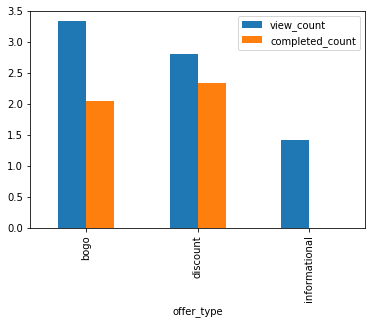

In [32]:
portfolio_counts.groupby('offer_type')['view_count','completed_count'].sum().reset_index().plot.bar(x='offer_type',y=['view_count','completed_count'])


I love the finding!. It is clear from the graph that in terms of views, the bogo is a bit higher than the rest. However, the most completed offers are the discount offers. (Here I'm assuming all viewed informational are completed, but still, the number is low compared to the rest!).


## Modeling

#### Can we build a model that can predict the behaviour of our costumers?

In [33]:
portfolio_2.id.unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [34]:
platforms = ['web', 'email', 'mobile', 'social']

for x in platforms:
    portfolio_2['ch_' + x] = portfolio_2['channels'].str.contains(x, regex=False)

new_col_order = [
    'id', 'offer_type', 'difficulty', 'duration', 'reward',
    'ch_web', 'ch_email', 'ch_mobile', 'ch_social'
]
portfolio_2 = portfolio_2[new_col_order]

rename_id = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_1',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo_2',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo_3',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo_4',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount_1',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount_2',
    'fafdcd668e3743c1bb461111dcafc2a4': 'discount_3',
    '2906b810c7d4411798c6938adc9daaa5': 'discount_4',
    '3f207df678b143eea3cee63160fa8bed': 'info_1',
    '5a8bc65990b245e5a138643cd4eb9837': 'info_2'

}
portfolio_2['id'] = portfolio_2['id'].map(rename_id) 

portfolio_2


,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo_1,bogo,10,7,10,False,True,True,True
1,bogo_2,bogo,10,5,10,True,True,True,True
2,info_1,informational,0,4,0,True,True,True,False
3,bogo_3,bogo,5,7,5,True,True,True,False
4,discount_1,discount,20,10,5,True,True,False,False
5,discount_2,discount,7,7,3,True,True,True,True
6,discount_3,discount,10,10,2,True,True,True,True
7,info_2,informational,0,3,0,False,True,True,True
8,bogo_4,bogo,5,5,5,True,True,True,True
9,discount_4,discount,10,7,2,True,True,True,False


In [35]:
profile_2.became_member_on = pd.to_datetime(profile_2.became_member_on.astype(int), format='%Y%m%d')

In [36]:
profile

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN


In [37]:
profile_2.dropna(inplace = True)


ids = {}

i = 1
for x in profile_2.id.unique():
    ids[x] = 'person_' + str(i)
    i = i+1

profile_2['id'] = profile_2['id'].map(ids)


In [38]:
profile_2

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,person_1,112000.0
3,75,2017-05-09,F,person_2,100000.0
5,68,2018-04-26,M,person_3,70000.0
8,65,2018-02-09,M,person_4,53000.0
12,58,2017-11-11,M,person_5,51000.0
13,61,2017-09-11,F,person_6,57000.0
14,26,2014-02-13,M,person_7,46000.0
15,62,2016-02-11,F,person_8,71000.0
16,49,2014-11-13,M,person_9,52000.0
18,57,2017-12-31,M,person_10,42000.0


In [39]:
transcript_amount = transcript_2[transcript_2['event'] == 'transaction'].copy()
transcript_amount['amount'] = transcript_amount['value'].apply(lambda x: x['amount'])
transcript_amount = transcript_amount.drop(['event', 'value'], axis=1)

transcript_amount['person'] = transcript_amount['person'].map(ids)
transcript_amount.head()


,person,time,amount
12654,person_29,0,0.83
12657,person_40,0,34.56
12659,person_46,0,13.23
12670,person_108,0,19.51
12671,person_124,0,18.97


In [40]:
transcript_reaction = transcript_2[transcript_2['event'] != 'transaction'].copy()
transcript_reaction['offer_id'] = transcript_reaction['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else x['offer id'])
transcript_reaction = transcript_reaction.drop(['value'], axis=1)

transcript_reaction['offer_id'] = transcript_reaction['offer_id'].map(rename_id)

transcript_reaction['person'] = transcript_reaction['person'].map(ids)

transcript_reaction.head()


,event,person,time,offer_id
0,offer received,person_2,0,bogo_3
1,offer received,NaN,0,discount_1
2,offer received,person_3,0,discount_4
3,offer received,NaN,0,discount_3
4,offer received,NaN,0,bogo_2


In [41]:

offers = []
for x in transcript_reaction['offer_id'].unique():
    y  = transcript_reaction[transcript_reaction['offer_id'] == x].groupby('event').size().to_dict()
    y['id'] = x
    offers.append(y)

In [42]:
offers_1 = pd.DataFrame(offers)[['id', 'offer received', 'offer viewed', 'offer completed']]

# Compute the rate
offers_1['offer_complete_rate'] = offers_1['offer completed'] / offers_1['offer received']
offers_1['offer_view_rate'] = offers_1['offer viewed'] / offers_1['offer received']



In [43]:
offers_1

,id,offer received,offer viewed,offer completed,offer_complete_rate,offer_view_rate
0,bogo_3,7677,4171,4354.0,0.567149,0.543311
1,discount_1,7668,2663,3420.0,0.446009,0.347287
2,discount_4,7632,4118,4017.0,0.526336,0.539570
3,discount_3,7597,7327,5317.0,0.699882,0.964460
4,bogo_2,7593,7298,3331.0,0.438694,0.961148
5,bogo_4,7571,7264,4296.0,0.567428,0.959451
6,discount_2,7646,7337,5156.0,0.674340,0.959587
7,info_1,7617,4144,NaN,NaN,0.544046
8,bogo_1,7658,6716,3688.0,0.481588,0.876991
9,info_2,7618,6687,NaN,NaN,0.877789


In [44]:
portfolio_2

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo_1,bogo,10,7,10,False,True,True,True
1,bogo_2,bogo,10,5,10,True,True,True,True
2,info_1,informational,0,4,0,True,True,True,False
3,bogo_3,bogo,5,7,5,True,True,True,False
4,discount_1,discount,20,10,5,True,True,False,False
5,discount_2,discount,7,7,3,True,True,True,True
6,discount_3,discount,10,10,2,True,True,True,True
7,info_2,informational,0,3,0,False,True,True,True
8,bogo_4,bogo,5,5,5,True,True,True,True
9,discount_4,discount,10,7,2,True,True,True,False


In [45]:
df_1 = portfolio_2.copy()
df_1 = df_1.join(offers_1.set_index('id'), on='id').drop(['offer received', 'offer viewed', 'offer completed'], axis=1)


In [46]:
df_1 = df_1[['id', 'offer_type', 'difficulty', 'duration', 'reward', 'offer_complete_rate', 'offer_view_rate']]


In [47]:
df_1

,id,offer_type,difficulty,duration,reward,offer_complete_rate,offer_view_rate
0,bogo_1,bogo,10,7,10,0.481588,0.876991
1,bogo_2,bogo,10,5,10,0.438694,0.961148
2,info_1,informational,0,4,0,NaN,0.544046
3,bogo_3,bogo,5,7,5,0.567149,0.543311
4,discount_1,discount,20,10,5,0.446009,0.347287
5,discount_2,discount,7,7,3,0.674340,0.959587
6,discount_3,discount,10,10,2,0.699882,0.964460
7,info_2,informational,0,3,0,NaN,0.877789
8,bogo_4,bogo,5,5,5,0.567428,0.959451
9,discount_4,discount,10,7,2,0.526336,0.539570


In [48]:
spending_dict = transcript_amount.groupby(['person'])['amount'].sum().to_dict()

In [49]:
bogo_count = portfolio_2[portfolio_2.id.str.contains('bogo')].id.values
discount_count = portfolio_2[portfolio_2.id.str.contains('discount')].id.values

stats_1 = []
for x in transcript_reaction['person'].unique():

    discount_offer = transcript_reaction[transcript_reaction.offer_id.isin(discount_count)]
    discount_offer = discount_offer[discount_offer['person'] == x].groupby('event').size()
    discount_offer = discount_offer.rename({'offer received': 'discount offer received', 'offer viewed': 'discount offer viewed', 'offer completed': 'discount offer completed'})

    bogo_offer = transcript_reaction[transcript_reaction.offer_id.isin(bogo_count)]
    bogo_offer = bogo_offer[bogo_offer['person'] == x].groupby('event').size()
    bogo_offer = bogo_offer.rename({'offer received': 'bogo offer received', 'offer viewed': 'bogo offer viewed', 'offer completed': 'bogo offer completed'})

    

    
    stats = bogo_offer.to_dict()
    stats.update(discount_offer.to_dict())
    stats['person'] = x
    stats_1.append(stats)


    
    
col = ['person', 'bogo offer received', 'bogo offer viewed', 'bogo offer completed', 'discount offer received', 'discount offer viewed', 'discount offer completed']
df_person_stat = pd.DataFrame(stats_1)[col].fillna(0)


In [50]:
df_person_stat['bogo_offer_view_rate'] = df_person_stat['bogo offer viewed'] / df_person_stat['bogo offer received']
df_person_stat['bogo_offer_complete_rate'] = df_person_stat['bogo offer completed'] / df_person_stat['bogo offer received']
df_person_stat['discount_offer_view_rate'] = df_person_stat['discount offer viewed'] / df_person_stat['discount offer received']
df_person_stat['discount_offer_complete_rate'] = df_person_stat['discount offer completed'] / df_person_stat['discount offer received']
df_person_stat = df_person_stat[['person', 'bogo_offer_view_rate', 'bogo_offer_complete_rate', 'discount_offer_view_rate', 'discount_offer_complete_rate']]
df_person_stat.head(3)


,person,bogo_offer_view_rate,bogo_offer_complete_rate,discount_offer_view_rate,discount_offer_complete_rate
0,person_2,1.0,1.0,NaN,NaN
1,0,NaN,NaN,NaN,NaN
2,person_3,1.0,1.0,1.0,0.5


In [51]:
df_2 = profile_2.join(df_person_stat.set_index('person'), on='id') 
df_2['spending'] = df_2['id'].map(spending_dict).fillna(0) 

df_2 = df_2.drop(['id'], axis=1)

df_2.head(3)

,age,became_member_on,gender,income,bogo_offer_view_rate,bogo_offer_complete_rate,discount_offer_view_rate,discount_offer_complete_rate,spending
1,55,2017-07-15,F,112000.0,0.0,1.0,NaN,NaN,77.01
3,75,2017-05-09,F,100000.0,1.0,1.0,NaN,NaN,159.27
5,68,2018-04-26,M,70000.0,1.0,1.0,1.0,0.5,57.73


In [52]:
import dateutil


latest = profile_2[profile_2.became_member_on == profile_2.became_member_on.max()].id

after_latest = transcript_reaction[transcript_reaction.person.isin(latest)].time.max()


In [53]:
after_latest

708

In [54]:
last_times = df_2.became_member_on.max() + dateutil.relativedelta.relativedelta(hours=float(after_latest))

In [55]:
df_2['membership_duration'] = df_2['became_member_on'].apply(lambda x: (last_times - x).days)
df_2 = df_2.drop(['became_member_on'], axis=1)
df_2[['age', 'gender', 'income', 'membership_duration', 'spending', 'bogo_offer_view_rate', 'bogo_offer_complete_rate', 'discount_offer_view_rate', 'discount_offer_complete_rate']].head(3)


,age,gender,income,membership_duration,spending,bogo_offer_view_rate,bogo_offer_complete_rate,discount_offer_view_rate,discount_offer_complete_rate
1,55,F,112000.0,405,77.01,0.0,1.0,NaN,NaN
3,75,F,100000.0,472,159.27,1.0,1.0,NaN,NaN
5,68,M,70000.0,120,57.73,1.0,1.0,1.0,0.5


In [56]:
df_3 = df_2.drop(['bogo_offer_view_rate', 'bogo_offer_complete_rate', 'discount_offer_view_rate', 'discount_offer_complete_rate', 'spending'], axis=1).copy()

In [57]:
df_3

,age,gender,income,membership_duration
1,55,F,112000.0,405
3,75,F,100000.0,472
5,68,M,70000.0,120
8,65,M,53000.0,196
12,58,M,51000.0,286
13,61,F,57000.0,347
14,26,M,46000.0,1653
15,62,F,71000.0,925
16,49,M,52000.0,1380
18,57,M,42000.0,236


In [58]:
def encoding (df, col):
    """ One-hot encoding function
    
    Args:
        df: DataFrame
        cols: a list of columns to encode 
    Returns:
        a DataFrame with one-hot encoding
        
    """
    for each in col:
        x = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, x], axis=1)
        df = df.drop([each], axis=1)
    return df


In [59]:
df_3 = encoding(df_3, ['gender'])
df_3.head(3)


,age,income,membership_duration,gender_F,gender_M,gender_O
1,55,112000.0,405,1,0,0
3,75,100000.0,472,1,0,0
5,68,70000.0,120,0,1,0


In [60]:
colom = list(df_3.select_dtypes(include=['int64','uint8']))


for col in colom:
    df_3[col] = df_3[col].astype(np.float64)


In [61]:
ss = StandardScaler()

for col in df_3.columns:
    df_3[col] = ss.fit_transform(df_3[col].values.reshape(-1, 1))

df_3.head(3)


,age,income,membership_duration,gender_F,gender_M,gender_O
1,0.034889,2.157419,-0.349433,1.191146,-1.156702,-0.120448
3,1.185430,1.601801,-0.189601,1.191146,-1.156702,-0.120448
5,0.782741,0.212756,-1.029314,-0.839528,0.864527,-0.120448


In [62]:
from sklearn.decomposition import PCA

pca = PCA()
df_4= pca.fit(df_3)


In [63]:

dd = ['D- {}'.format(i) for i in range(1, len(pca.components_)+1)]
cc = pd.DataFrame(np.round(pca.components_, 4), columns = df_3.keys())
cc.index = dd


In [64]:
rr = df_4.explained_variance_ratio_.reshape(len(pca.components_), 1)
vv = pd.DataFrame(np.round(rr, 4), columns = ['Explained Variance'])
vv.index = dd

pca_result = pd.concat([vv, cc], axis=1)
pca_result.head()


,Explained Variance,age,income,membership_duration,gender_F,gender_M,gender_O
D- 1,0.3578,0.2569,0.3235,-0.0124,0.6430,-0.6445,0.0184
D- 2,0.1915,-0.6578,-0.5789,-0.2386,0.2532,-0.2910,0.1624
D- 3,0.1711,0.1560,0.0853,-0.1205,-0.1829,-0.0479,0.9582
D- 4,0.1651,-0.1681,-0.0980,0.9627,0.0458,-0.0844,0.1617
D- 5,0.1145,0.6699,-0.7371,0.0400,0.0562,-0.0487,-0.0301


Text(0,0.5,'Variance Explained (%)')

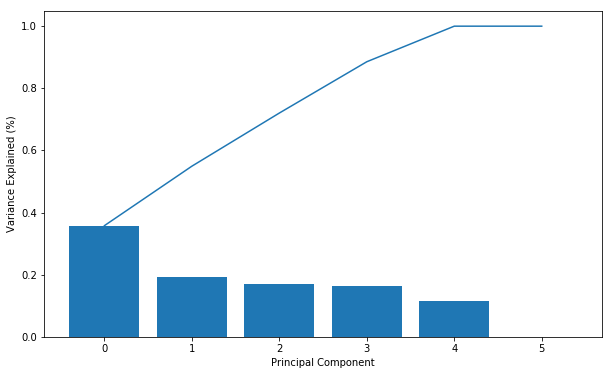

In [65]:
comp = len(df_4.explained_variance_ratio_)

n = np.arange(comp)
values = df_4.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cum_values = np.cumsum(values)
ax.bar(n, values)
ax.plot(n, cum_values)


ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")


In [66]:
pca = PCA(n_components=5, random_state=10)
df_5 = pca.fit_transform(df_3)


In [67]:
from sklearn.cluster import KMeans


def kmean_calculate(data, n):
    k_means = KMeans(n_clusters=n, random_state=10).fit(data)
    return k_means.inertia_


In [68]:
c = [3,9,12,20]
sse = []

for i in c:
    sse.append(kmean_calculate(df_5, i))


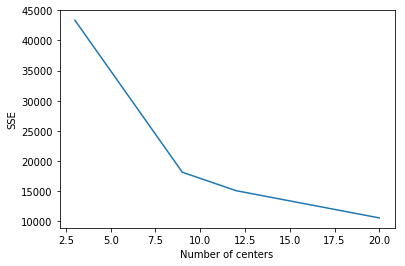

In [69]:
plt.plot(c, sse)
plt.xlabel('Number of centers')
plt.ylabel('SSE')
plt.show()


In [70]:
mod = KMeans(n_clusters=8, random_state=10).fit(df_5)
predition = mod.predict(df_5)


In [71]:
clusters = []
for i in range(8):
    clusters.append(df_2[predition==i])


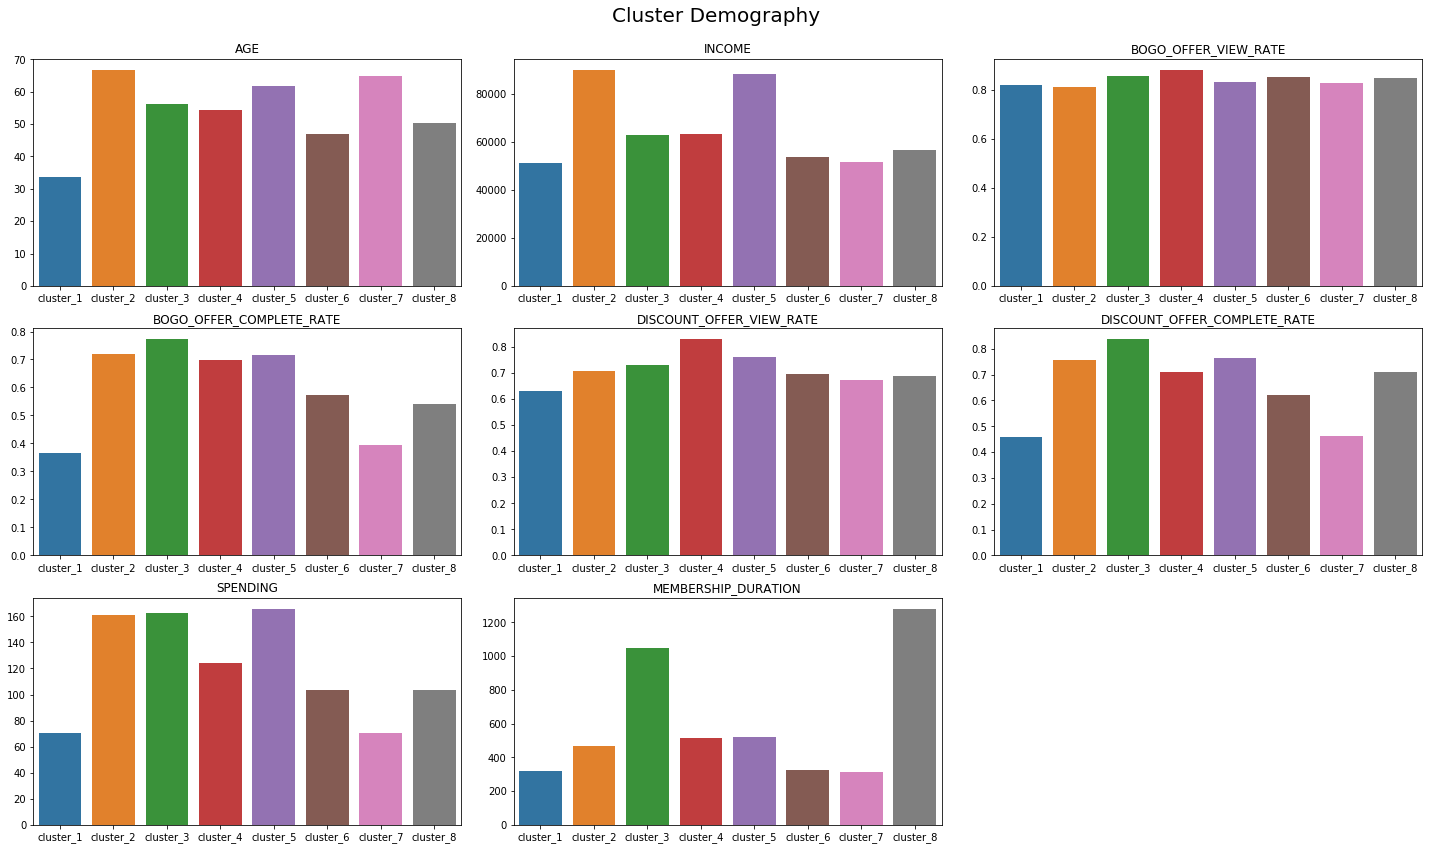

In [72]:
labels = ['cluster_{}'.format(n+1) for n in range(8)]
n_graphing = [col for col in df_2.columns if df_2[col].dtype in [np.float64, np.int64]]

fig = plt.figure(figsize=(20, 12))
fig.suptitle('Cluster Demography', fontsize=20)

numberOfCol = 3
numberOfRow = len(n_graphing) // numberOfCol + 1
for n, col in enumerate(n_graphing) :
    ax = fig.add_subplot(numberOfRow,numberOfCol, n+1)

    vals = []
    for i in range(8):
        vals.append(clusters[i][col].mean())
    sns.barplot(labels,vals, ax=ax)

    ax.set_title(col.upper())

plt.tight_layout()
fig.subplots_adjust(top=0.92)


In [73]:
for i, cluster in enumerate(clusters):
    print('cluster {}: {}'.format(i+1, clusters[i].gender.mode().values[0]))

cluster 1: M
cluster 2: F
cluster 3: F
cluster 4: O
cluster 5: M
cluster 6: F
cluster 7: M
cluster 8: M


In [79]:
from sklearn.metrics import silhouette_score

score = silhouette_score (df_5, predition, metric='euclidean')
print ("For n_clusters = {}, silhouette score is {})".format(clusters, score))



For n_clusters = [       age gender   income  bogo_offer_view_rate  bogo_offer_complete_rate  \
32      22      M  70000.0              1.000000                  0.666667   
34      40      M  33000.0              0.600000                  0.200000   
42      45      M  33000.0              1.000000                  0.666667   
59      45      M  48000.0              1.000000                  0.000000   
60      29      M  50000.0                   NaN                       NaN   
61      44      M  35000.0              1.000000                  1.000000   
63      36      M  56000.0                   NaN                       NaN   
78      30      M  41000.0              1.000000                  0.000000   
82      27      M  35000.0              1.000000                  0.000000   
83      40      M  53000.0              1.000000                  0.000000   
101     45      M  54000.0              1.000000                  0.000000   
116     18      M  47000.0              0.5000

In [85]:
mod_2 = KMeans(n_clusters=11, random_state=10).fit(df_5)
predition_2 = mod_2.predict(df_5)

score_2 = silhouette_score (df_5, predition_2, metric='euclidean')
print ("For n_clusters = {}, silhouette score is {})".format(clusters, score_2))


For n_clusters = [       age gender   income  bogo_offer_view_rate  bogo_offer_complete_rate  \
32      22      M  70000.0              1.000000                  0.666667   
34      40      M  33000.0              0.600000                  0.200000   
42      45      M  33000.0              1.000000                  0.666667   
59      45      M  48000.0              1.000000                  0.000000   
60      29      M  50000.0                   NaN                       NaN   
61      44      M  35000.0              1.000000                  1.000000   
63      36      M  56000.0                   NaN                       NaN   
78      30      M  41000.0              1.000000                  0.000000   
82      27      M  35000.0              1.000000                  0.000000   
83      40      M  53000.0              1.000000                  0.000000   
101     45      M  54000.0              1.000000                  0.000000   
116     18      M  47000.0              0.5000

In [90]:
mod_3 = KMeans(n_clusters=7, random_state=10).fit(df_5)
predition_3 = mod_3.predict(df_5)

score_3 = silhouette_score (df_5, predition_3, metric='euclidean')
print ("For n_clusters = {}, silhouette score is {})".format(clusters, score_3))


For n_clusters = [       age gender   income  bogo_offer_view_rate  bogo_offer_complete_rate  \
32      22      M  70000.0              1.000000                  0.666667   
34      40      M  33000.0              0.600000                  0.200000   
42      45      M  33000.0              1.000000                  0.666667   
59      45      M  48000.0              1.000000                  0.000000   
60      29      M  50000.0                   NaN                       NaN   
61      44      M  35000.0              1.000000                  1.000000   
63      36      M  56000.0                   NaN                       NaN   
78      30      M  41000.0              1.000000                  0.000000   
82      27      M  35000.0              1.000000                  0.000000   
83      40      M  53000.0              1.000000                  0.000000   
101     45      M  54000.0              1.000000                  0.000000   
116     18      M  47000.0              0.5000